In [1]:
%pip install numpy
%pip install pandas
%pip install torch
%pip install tqdm
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import os
import math

# Linear MDP

`LinearMDP` implements the standard *linear MDP model*, where both rewards and transition probabilities are expressed as **linear functions of the state–action feature map**.
Given a set of states and actions, a feature extractor `phi(x,a)`, and a reward weight vector `omega`, the class constructs the reward function as `r(x,a) = <phi(x,a), omega>`.
Transitions can be specified in two interchangeable ways:

1. **Via linear transition weights `psi[x']`**, where each next-state `x'` has an associated weight vector that linearly determines `P(x'|x,a) = <phi(x,a), psi[x']>`; or
2. **Via a full explicit transition matrix `P`** of shape `(N*A, N)`.

The constructor also computes the feature dimension, the max feature norm bound `R`, stores the discount factor `gamma` and initial state `x0`, and provides utilities to obtain the reward vector, construct the transition matrix, and inspect a given policy.
This class is meant to serve as a compact and explicit representation of linear MDPs for FOGAS experimentation.

**`__init__`**
Initializes the linear MDP, loads the feature map, reward weights, transition specification, and computes all structural dimensions and bounds.

**`get_reward`**
Returns the flat reward vector where each entry is `<phi(x,a), omega>`.

**`get_transition_matrix`**
Constructs or returns the transition matrix `P` and validates that it forms proper probability distributions.

**`print_policy`**
Displays the action probabilities of a policy for each state and marks the best action.


In [2]:
class LinearMDP:
    def __init__(
        self,
        states,
        actions,
        phi,
        omega,
        gamma,
        x0,
        psi=None,
        P=None,
    ):
        """
        states: array-like of state indices
        actions: array-like of action indices
        phi: function phi(x,a) -> R^d
        omega: reward weight vector (d,)
        psi: dict mapping next_state -> weight vector (d,)  (optional)
        P: explicit transition matrix (N*A, N) if psi not given
        gamma: discount factor
        x0: initial state
        """

        self.states = np.array(states)
        self.actions = np.array(actions)
        self.N = len(states)
        self.A = len(actions)

        # feature map
        self.phi = phi
        self.d = len(phi(states[0], actions[0]))

        # upper bound on feature norms
        self.R = np.max([
            np.linalg.norm(phi(s, a))
            for s in states
            for a in actions
        ])

        # reward weights
        self.omega = np.array(omega)

        # psi or P
        if psi is not None:
            self.psi = {s: np.array(psi[s]) for s in psi}
            self.given_psi = True
            self.P = None
        else:
            self.psi = None
            self.P = np.array(P)
            self.given_psi = False

        self.gamma = gamma
        self.x0 = x0

    # ------------------------------------------------------------
    # Reward computation: r = Φω
    # ------------------------------------------------------------
    def get_reward(self, verbose=False):
        """
        Returns r of shape (N*A,)
        r[x,a] = <phi(x,a), omega>
        """
        r = np.zeros(self.N * self.A)
        idx = 0
        for x in range(self.N):
            for a in range(self.A):
                r[idx] = self.phi(x, a) @ self.omega
                idx += 1

        if verbose:
            print("\n=== Reward Vector r ===")
            print("Shape:", r.shape)
            for x in range(self.N):
                for a in range(self.A):
                    print(f"r(s={x}, a={a}) = {self.phi(x,a) @ self.omega:.4f}")
            print("")

        return r


    # ------------------------------------------------------------
    # Transition matrix P of shape (N*A, N)
    # ------------------------------------------------------------
    def get_transition_matrix(self, verbose=False):
        """
        Returns a probability matrix P of shape (N*A, N)
        If psi is given, constructs:
            P[x,a,x'] = <phi(x,a), psi[x']>
        Otherwise returns already provided P.
        """

        # Construct P from psi
        if self.given_psi:
            P = np.zeros((self.N * self.A, self.N))
            idx = 0
            for x in range(self.N):
                for a in range(self.A):
                    for xp in range(self.N):
                        P[idx, xp] = self.phi(x, a) @ self.psi[xp]
                    idx += 1
        else:
            P = self.P.copy()

        # Check if valid probability matrix
        eps = 1e-12
        negative_entries = np.any(P < -eps)
        row_sums = P.sum(axis=1)
        invalid_rows = np.where(np.abs(row_sums - 1) > 1e-6)[0]

        if verbose:
            print("\n=== Transition Matrix P ===")
            print("Shape:", P.shape)
            print("First few rows:\n", P[:min(5, len(P)), :], "\n")

            if not negative_entries:
                print("✔ No negative probabilities detected.")
            else:
                print("✘ WARNING: Negative probabilities detected!")

            if len(invalid_rows) == 0:
                print("✔ All rows sum to 1 (valid probability matrix).")
            else:
                print("✘ WARNING: Some rows do not sum to 1:")
                for i in invalid_rows[:10]:
                    print(f"  Row {i}: sum = {row_sums[i]:.6f}")

        return P
    
    def print_policy(self, pi):
        for i, s in enumerate(self.states):
            best_a_idx = np.argmax(pi[i])
            best_action = self.actions[best_a_idx]

            print(f"  State {s}: ", end="")
            for j, a in enumerate(self.actions):
                print(f"π(a={a}|s={s}) = {pi[i, j]:.2f}  ", end="")
            print(f"--> best action: {best_action}")
        print()

# Policy Solver

`PolicySolver` extends `LinearMDP` by adding core **planning and analysis tools** typically used in dynamic programming.
Upon initialization, it automatically builds the reward vector and transition matrix from the parent `LinearMDP`, computes the **optimal deterministic policy** via policy iteration, obtains its associated **value and Q-functions**, and derives the **discounted occupancy measure** of the optimal policy.
The class provides utilities to:

* evaluate any policy (compute its `v` and `q`),
* run policy iteration (deterministic or softmax),
* compute occupancy measures of arbitrary policies, and
* pretty-print values, Q-values, policies, and occupancy tables.
  It is meant to serve as a compact solver for small/medium linear MDPs where closed-form DP methods are feasible and useful for validating algorithms like FOGAS.


**`__init__`**
Loads inherited linear MDP structure, precomputes reward/transition matrices, runs policy iteration to obtain the optimal policy, and computes its occupancy measure.

**`evaluate_policy`**
Computes the value function `v` and action-value function `q` of a given policy `pi` using linear system solving.

**`policy_iteration`**
Iteratively evaluates and improves a policy until convergence, returning the final policy along with its value and Q-functions.

**`print_results`**
Pretty-prints a given policy, its value function, and its Q-function in a readable diagnostic format.

**`occupancy_measure`**
Computes the discounted state–action occupancy measure `μ^π` for any policy using a linear system over `(N*A)` variables.

**`print_occupancy`**
Prints the occupancy measure in matrix form, showing occupancy of each action in each state and row/total sums.


In [3]:
class PolicySolver(LinearMDP):
    """
    Extends LinearMDP with evaluation, iteration, occupancy measure,
    and pretty-printing utilities.
    """
    def __init__(self, mode="deterministic", *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Precompute reward & transition matrix
        self.r = self.get_reward(verbose=False)
        self.P = self.get_transition_matrix(verbose=False)

        # Compute deterministic optimal policy π*
        self.pi_star, self.v_star, self.q_star = self.policy_iteration(
            mode=mode,
            verbose=False
        )

        # Compute discounted occupancy measure μ*
        self.mu_star = self.occupancy_measure(
            pi=self.pi_star,
            nu0=None,
        )


    # ------------------------------------------------------------
    # Policy Evaluation
    # ------------------------------------------------------------
    def evaluate_policy(self, pi, verbose=False):

        r = self.r
        P = self.P

        r_pi = (pi * r.reshape(self.N, self.A)).sum(axis=1)

        P_pi = np.zeros((self.N, self.N))
        for a in range(self.A):
            P_pi += np.diag(pi[:, a]) @ P[a::self.A, :]

        v = np.linalg.solve(np.eye(self.N) - self.gamma * P_pi, r_pi)
        q = (r + self.gamma * P @ v).reshape(self.N, self.A)

        if verbose:
            self.print_results(pi=pi, v=v, q=q)

        return v, q


    # ------------------------------------------------------------
    # Policy Iteration
    # ------------------------------------------------------------
    def policy_iteration(self, mode="deterministic", temperature=1.0,
                         max_iter=1000, eps=1e-8, verbose=False):

        pi = np.ones((self.N, self.A)) / self.A

        for it in range(max_iter):

            v, q = self.evaluate_policy(pi)

            if mode == "deterministic":
                new_pi = np.zeros_like(pi)
                best_a = np.argmax(q, axis=1)
                new_pi[np.arange(self.N), best_a] = 1.0

            elif mode == "softmax":
                logits = q / temperature
                logits -= logits.max(axis=1, keepdims=True)
                new_pi = np.exp(logits)
                new_pi /= new_pi.sum(axis=1, keepdims=True)

            else:
                raise ValueError("mode must be 'deterministic' or 'softmax'")

            if np.allclose(new_pi, pi, atol=eps):
                if verbose:
                    print(f"Converged at iteration {it+1}")
                break

            pi = new_pi

        return pi, v, q


    # ------------------------------------------------------------
    # Pretty-print results (π, v, q)
    # ------------------------------------------------------------
    def print_results(self, pi=None, v=None, q=None):
        print("\n========== POLICY - VALUE RESULTS ==========\n")

        # Use actual state labels
        for idx, s in enumerate(self.states):
            if v is not None:
                print(f"State {s}: V = {v[idx]:.4f}")
        print()

        if q is not None:
            print("Action-Value Function (Q):")
            for i, s in enumerate(self.states):
                print(f"  State {s}:")
                for j, a in enumerate(self.actions):
                    print(f"    Action {a}: Q(s={s}, a={a}) = {q[i, j]:.4f}")
                print()

        if pi is not None:
            self.print_policy(pi)

        print("=============================================\n")

    def print_optimals(self, occupancy=False):
        self.print_results(self.pi_star, self.v_star, self.q_star)
        if occupancy:
            self.print_occupancy(self.mu_star)

    # ------------------------------------------------------------
    # Compute Occupancy Measure μ^π  
    # ------------------------------------------------------------
    def occupancy_measure(self, pi, nu0=None):

        if nu0 is None:
            nu0 = np.zeros(self.N)
            nu0[self.x0] = 1.0

        Comp_pi = np.zeros((self.N * self.A, self.N))
        for x in range(self.N):
            for a in range(self.A):
                Comp_pi[x * self.A + a, x] = pi[x, a]

        I = np.eye(self.N * self.A)
        rhs = (1 - self.gamma) * (Comp_pi @ nu0)

        mu = np.linalg.solve(I - self.gamma * Comp_pi @ self.P.T, rhs)

        return mu

    # ------------------------------------------------------------
    # Pretty-print occupancy measure 
    # ------------------------------------------------------------
    def print_occupancy(self, mu):
        N, A = self.N, self.A
        mu_matrix = mu.reshape(N, A)

        print("\nDiscounted Occupancy Measure μ^π")
        print("--------------------------------")

        header = "State | " + " | ".join(f"{a:>8}" for a in self.actions) + " |   Sum"
        print(header)
        print("-" * len(header))

        for i, s in enumerate(self.states):
            row_vals = " | ".join(f"{mu_matrix[i, j]:8.5f}" for j in range(A))
            row_sum = np.sum(mu_matrix[i])
            print(f"{str(s):>5} | {row_vals} | {row_sum:6.5f}")

        total_sum = np.sum(mu_matrix)
        print("-" * len(header))
        print(f"Total sum = {total_sum:.6f} (should be ≈ 1.0)\n")


# Dataset Collection

`LinearMDPEnv` is a lightweight **Gym environment wrapper** around a `LinearMDP` or `PolicySolver` model, turning any linear MDP into a standard Gym interface usable for simulation, policy testing, and compatibility with reinforcement-learning algorithms.
It exposes the MDP’s states and actions as discrete observation/action spaces, samples transitions using the linear transition matrix `P`, and retrieves rewards from the precomputed reward vector `r`.
If no terminal (absorbing) states are provided, the environment automatically detects absorbing states by inspecting the transition dynamics: a state is absorbing if **every action deterministically returns to itself**.
Episodes start from a uniformly random initial state, terminate on reaching a terminal state, and may truncate after a maximum number of steps.
This wrapper is designed for collection of a dataset for FOGAS.

**`__init__`**
Builds the Gym environment from the given linear MDP, loads transitions/rewards, and optionally detects absorbing states.

**`_detect_absorbing_states`**
Scans the transition matrix to find states that are deterministic self-loops for all actions.

**`reset`**
Starts a new episode by sampling an initial state uniformly over all states.

**`step`**
Executes an action, samples the next state from the linear MDP transition probabilities, returns reward, and signals termination or truncation.


In [4]:
class LinearMDPEnv(gym.Env):
    """
    Gym wrapper for LinearMDP / PolicySolver, with:
      - automatic detection of absorbing states from P (if terminal_states=None)
      - random initial state at reset (uniform over states)
    """

    metadata = {"render_modes": ["human"]}

    def __init__(self, mdp, max_steps=100, terminal_states=None, tol=1e-8):
        super().__init__()

        self.mdp = mdp
        self.states = mdp.states
        self.actions = mdp.actions
        self.N = mdp.N
        self.A = mdp.A

        self.observation_space = spaces.Discrete(self.N)
        self.action_space = spaces.Discrete(self.A)

        self.max_steps = max_steps
        self.step_count = 0
        self.state = None

        # Always build P and r from the MDP interface
        self.P = mdp.P  # shape (N*A, N)
        self.r = mdp.r  # shape (N*A,)

        # If no terminal_states are provided, detect absorbing states from P
        if terminal_states is None:
            self.terminal_states = self._detect_absorbing_states(self.P, tol=tol)
            #if len(self.terminal_states) > 0:
                #print(f"[LinearMDPEnv] Detected goal states: {self.terminal_states}")
        else:
            self.terminal_states = set(terminal_states)

    # ------------------------------------------------
    # Helper: detect absorbing states from P
    # ------------------------------------------------
    def _detect_absorbing_states(self, P, tol=1e-8):
        """
        Detect absorbing states from P of shape (N*A, N).

        A state s is marked absorbing if for ALL actions a:
          - P(s'|s,a) is (approximately) a Dirac at s:
                sum_s' P(s'|s,a) ≈ 1
                P(s|s,a) ≈ 1
                P(s'!=s | s,a) ≈ 0
        """
        absorbing = []
        for s_idx, s in enumerate(self.states):
            is_absorbing = True
            for a_idx in range(self.A):
                row_idx = s_idx * self.A + a_idx
                probs = P[row_idx]  # size N

                # Conditions for absorbing under this action
                if not np.isclose(probs.sum(), 1.0, atol=tol):
                    is_absorbing = False
                    break
                if not np.isclose(probs[s_idx], 1.0, atol=tol):
                    is_absorbing = False
                    break
                # Optionally check other entries are ~0
                mask_others = np.ones(self.N, dtype=bool)
                mask_others[s_idx] = False
                if np.any(probs[mask_others] > tol):
                    is_absorbing = False
                    break

            if is_absorbing:
                absorbing.append(s)

        return set(absorbing)

    # ------------------------------------------------
    # Reset: random initial state
    # ------------------------------------------------
    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.step_count = 0

        # Random initial state (uniform over states)
        self.state = int(np.random.choice(self.states))
        return int(self.state), {}

    # ------------------------------------------------
    # Step
    # ------------------------------------------------
    def step(self, action):
        assert self.action_space.contains(action)

        # If already in a terminal state: stay there, zero reward, terminated
        if self.state in self.terminal_states:
            return int(self.state), 0.0, True, False, {"terminal_state": True}

        x_idx = int(np.where(self.states == self.state)[0][0])
        a_idx = int(action)

        row_idx = x_idx * self.A + a_idx

        probs = self.P[row_idx]
        next_state = int(np.random.choice(self.states, p=probs))
        reward = float(self.r[row_idx])

        self.state = next_state
        self.step_count += 1

        terminated = next_state in self.terminal_states
        truncated = self.step_count >= self.max_steps

        info = {}
        if terminated:
            info["terminal_state"] = True

        return int(next_state), reward, terminated, truncated, info

    def render(self):
        print(f"Current state: {self.state}")

    def close(self):
        pass

`EnvDataCollector` is a utility class designed to **build an environment** and **generate an offline RL dataset** in a unified way.
It can construct an environment from three sources:

1. a `LinearMDP`/`PolicySolver` (wrapped through `LinearMDPEnv`),
2. a Gym environment name (`gym.make(env_name)`),
3. or an already-instantiated Gym environment.
   Once the environment is ready, the class provides simple built-in policies (random or uniform) and a policy factory that interprets either policy objects or string identifiers.
   The main functionality is dataset collection: running the environment for a fixed number of steps, following a given behavior policy, and recording each transition `(s, a, r, s')` into a clean, ordered pandas DataFrame, optionally saving it to disk.

**`__init__`**
Constructs the environment from either an MDP, a Gym name, or a pre-built env, ensuring a unified interface for dataset collection.

**`RandomPolicy`**
Policy class that selects actions uniformly at random using the environment's action space.

**`collect_dataset`**
Runs the environment for `n_steps` using a behavior policy, records transitions into a DataFrame, and optionally saves them to disk.


In [5]:
class EnvDataCollector:
    """
    Helper class that:
      - builds an environment from:
          * a LinearMDP / PolicySolver (via LinearMDPEnv)
          * or a Gym env name (gym.make)
          * or a pre-instantiated env
      - collects datasets following a given policy
      - can instantiate policies by name ('random', 'uniform')
    """

    def __init__(self, mdp=None, env_name=None, env=None,
                 max_steps=1000, terminal_states=None):
        
        if env is not None:
            self.env = env

        elif mdp is not None:
            self.env = LinearMDPEnv(mdp, max_steps=max_steps,
                                    terminal_states=terminal_states)

        elif env_name is not None:
            self.env = gym.make(env_name)

        else:
            raise ValueError("You must provide either mdp, env_name, or env.")
        
    class RandomPolicy:
        """Chooses actions uniformly at random."""
        def __init__(self, action_space):
            self.action_space = action_space
        def sample(self, state):
            return self.action_space.sample()


    class UniformPolicy:
        """Uniform distribution over actions (same as RandomPolicy but deterministic interface)."""
        def __init__(self, action_space):
            self.action_space = action_space
        def sample(self, state):
            return np.random.choice(self.action_space.n)

    # --------------------------------------------
    # Policy factory
    # --------------------------------------------
    def _make_policy(self, policy):
        """
        Accepts:
            - a policy object with .sample()
            - or a string: "random", "uniform", "greedy"
        Returns a policy object with method sample(state).
        """

        # Already a policy object → return as is
        if hasattr(policy, "sample"):
            return policy

        # String name → build the corresponding policy
        if isinstance(policy, str):
            policy = policy.lower()

            if policy == "random":
                return self.RandomPolicy(self.env.action_space)

            elif policy == "uniform":
                return self.UniformPolicy(self.env.action_space)

            else:
                raise ValueError(f"Unknown policy name '{policy}'. Supported: "
                                 f"'random', 'uniform', 'greedy'.")

        raise ValueError("Policy must be a string or an object with a .sample() method.")

    # --------------------------------------------
    # Dataset collection
    # --------------------------------------------
    def collect_dataset(self, policy="random", n_steps=1000, save_path=None, verbose=True):
        """
        Collects transitions following behavior policy π_b and returns an ordered DataFrame.
        """
        env = self.env
        policy = self._make_policy(policy)  

        data = {
            "episode": [],
            "step": [],
            "state": [],
            "action": [],
            "reward": [],
            "next_state": []
        }

        episode, step = 0, 0
        obs, _ = env.reset()

        for i in range(n_steps):
            action = policy.sample(obs)
            next_obs, reward, terminated, truncated, _ = env.step(action)

            data["episode"].append(episode)
            data["step"].append(step)
            data["state"].append(obs)
            data["action"].append(action)
            data["reward"].append(reward)
            data["next_state"].append(next_obs)

            step += 1

            if terminated or truncated:
                episode += 1
                step = 0
                obs, _ = env.reset()
            else:
                obs = next_obs

        df = pd.DataFrame(data)

        # Optional saving
        if save_path is not None:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            df[["state", "action", "reward", "next_state"]].to_csv(save_path, index=False)

            if verbose:
                print(f"✅ Dataset saved to: {save_path}")
                print(f"   Total transitions: {len(df)}")

        return df


# FOGAS

`FOGASSolver` implements the full FOGAS algorithm for linear MDPs, taking as input a `LinearMDP`/`PolicySolver` instance and an offline dataset.
It loads the dataset, computes all theoretical parameters from the FOGAS paper (iteration count, radii, regularizers, step sizes), builds the empirical covariance matrices required by the algorithm, and then executes the primal–dual iterative scheme of FOGAS.
The solver keeps track of the entire trajectory of the averaged parameters `θ̄_t`, provides utilities to evaluate the expected primal gap, compute uniform baselines, and sweep hyperparameters for empirical sensitivity analysis.

 `__init__`

Initializes the solver, loads the dataset, extracts MDP dimensions, computes all FOGAS constants, builds Φ, Λₙ, Λₙ⁻¹, and prepares storage for the optimization iterates.

`load_dataset`

Loads a CSV dataset of transitions and extracts arrays of states, actions, rewards, and next states, validating required columns.

`_compute_parameters`

Computes all theoretical FOGAS parameters (`T_min`, `T`, `D_theta`, `alpha`, `rho`, `eta`, `D_pi`, `beta`) based on dataset size, feature bounds, and discount factor, optionally printing them.

`_build_covariances`

Constructs feature matrix Φ, empirical covariance Λₙ, and its inverse using ridge regularization induced by β.

`softmax_policy`

Builds a softmax policy given a vector `θ̄`, returning either a function `π(x)` or the full `(N, A)` probability matrix.

`run`

**Executes the full FOGAS primal–dual optimization loop.**
This includes:

* Selecting hyperparameters (or using overrides).
* Initializing dual variable `λ_t`, averaged primal parameter `θ̄_t`, and initial uniform policy.
* Computing the empirical feature occupancy estimator at each iteration.
* Solving the primal minimization step to obtain `θ_t` on the boundary of the ℓ₂ ball.
* Updating the averaged parameter `θ̄_t` and updating the policy via softmax.
* Computing the smoothed empirical Bellman update term `Ψ̂ v_{θ_t, π_t}`.
* Performing the mirror-ascent update for `λ_t`.
* Storing all averaged iterates in `theta_bar_history`.

After completing `T` iterations, the method samples a random iterate `J ∼ Uniform{1…T}`, constructs the corresponding policy `π^J`, stores the full trajectory, and returns `π^J`.

`compute_expected_gap`

Samples several random `J` indices from the stored `θ̄` trajectory to estimate
**E_J ⟨ μ* − μ^{π^J}, r ⟩**,
the expected primal gap, using the exact occupancy of the optimal policy and the MDP’s reward vector.

 `compute_baseline_gap`

Computes the gap produced by the **uniform policy**, i.e.,
⟨ μ* − μ^{π_uniform}, r ⟩,
serving as a baseline reference for FOGAS performance.

---

 `sweep_parameter_and_plot`

Runs FOGAS multiple times by sweeping one hyperparameter (α, η, ρ, D_θ, or T), computes the expected gap for each value, and plots the results alongside the uniform baseline.


In [ ]:
class FOGASSolver:
    """
    FOGAS implementation for a given LinearMDP / PolicySolver and offline dataset.
    """

    def __init__(
        self,
        mdp,
        csv_path,   
        delta=0.05,              # confidence
        T=None,
        alpha=None,
        eta=None,
        rho=None,
        D_theta=None,
        print_params=False,
    ):
        """
        mdp      : LinearMDP / PolicySolver instance
        csv_path : path where dataset is
        delta    : confidence parameter
        """

        self.mdp = mdp
        self.Xs, self.As, self.Rs, self.X_nexts = self.load_dataset(csv_path=csv_path)
        self.delta = delta

        # Basic dimensions
        self.n = len(self.Xs)
        self.N = mdp.N
        self.A = mdp.A
        self.d = mdp.d
        self.gamma = mdp.gamma
        self.R = mdp.R            # bound on feature vectors
        self.phi = mdp.phi
        self.omega = mdp.omega
        self.x0 = mdp.x0

        # ---------------------------------------------------------
        # Theoretical parameters
        # ---------------------------------------------------------
        self._compute_parameters(T, alpha, eta, rho, D_theta, print_params=print_params)

        # ---------------------------------------------------------
        # Build Phi, Λ_n, Λ_n^{-1}
        # ---------------------------------------------------------
        self._build_covariances(print_params=print_params)

        # To store outputs from run()
        self.theta_bar_history = None
        self.pi = None

    def load_dataset(self, csv_path, verbose=False):
        """
        Loads a dataset saved in CSV format (columns: state, action, reward, next_state)
        and converts it into arrays for FOGAS algorithm.

        Parameters
        ----------
        csv_path : str
            Path to the CSV dataset file.
        verbose : bool, optional
            If True, prints dataset summary.

        Returns
        -------
        X : np.ndarray
        A : np.ndarray 
        R : np.ndarray 
        X_next : np.ndarray 
        """
        # --- Load CSV ---
        df = pd.read_csv(csv_path)

        # --- Check columns ---
        required_cols = ["state", "action", "reward", "next_state"]
        for col in required_cols:
            if col not in df.columns:
                raise ValueError(f"Missing required column: '{col}'")

        # --- Extract as numpy arrays ---
        Xs = df["state"].to_numpy(dtype=np.int64)
        As = df["action"].to_numpy(dtype=np.int64)
        Rs = df["reward"].to_numpy(dtype=np.float32)
        X_nexts = df["next_state"].to_numpy(dtype=np.int64)

        if verbose:
            print(f"✅ Loaded dataset: n = {len(df)} transitions from {csv_path}")
            print(f"   States: {np.unique(Xs)} | Actions: {np.unique(As)}")
            print(f"   Avg reward: {Rs.mean():.3f}")

        return Xs, As, Rs, X_nexts

    # ---------------------------------------------------------
    # Parameter computation
    # ---------------------------------------------------------
    def _compute_parameters(self, T=None, alpha=None, eta=None, rho=None, D_theta=None, print_params=False):
        delta = self.delta
        R = self.R
        n = self.n
        A = self.A
        alpha = 0.5, 
        d = self.d
        gamma = self.gamma

        self.T_min = 2 * (R**2) * n * np.log(A) / np.log(1 / delta)
        self.T = math.ceil(self.T_min) if T is None else T
        self.D_theta = np.sqrt(d / (1 - gamma)) if D_theta is None else D_theta
        self.alpha = np.sqrt((2 * (1 - gamma)**2 * np.log(A)) / (R**2 * d * self.T)) if alpha is None else alpha
        self.rho = gamma * np.sqrt((320 * d**2 * np.log(2 * self.T / delta)) / ((1 - gamma)**2 * n)) if rho is None else rho
        self.eta = np.sqrt(((1 - gamma)**2) / (27 * R**2 * d**2 * self.T)) if eta is None else eta
        self.D_pi = self.alpha * self.T * self.D_theta
        self.beta = R**2 / (d * self.T)
        self.mod_alpha = self.alpha

        if print_params:
            print("\n" + "="*60)
            print("                FOGAS PARAMETER SUMMARY")
            print("="*60)

            print(f"{'Dataset size n:':25s} {n}")
            print(f"{'Feature norm bound R:':25s} {R:.4f}")
            print(f"{'Num states N:':25s} {self.N}")
            print(f"{'Num actions A:':25s} {A}")
            print(f"{'Feature dim d:':25s} {d}")
            print(f"{'Discount γ:':25s} {gamma}")

            print("\n--- Theoretical Quantities ---")
            print(f"{'T_min (theoretical):':25s} {self.T_min:.4f}")
            print(f"{'T (iterations):':25s} {self.T}")
            print(f"{'β (ridge param):':25s} {self.beta:.6f}")

            print("\n--- FOGAS Hyperparameters ---")
            print(f"{'D_theta:':25s} {self.D_theta:.6f}")
            print(f"{'alpha:':25s} {self.alpha:.6f}")
            print(f"{'rho:':25s} {self.rho:.6f}")
            print(f"{'eta:':25s} {self.eta:.6f}")
            print(f"{'D_pi:':25s} {self.D_pi:.6f}")

            print("="*60 + "\n")


    # ---------------------------------------------------------
    # Build Φ, Λ_n, Λ_n^{-1}
    # ---------------------------------------------------------
    def _build_covariances(self, print_params=False):
        n = self.n
        d = self.d
        beta = self.beta
        phi = self.phi
        Xs = self.Xs
        As = self.As

        # Φ: (n, d)
        Phi = np.stack([phi(int(x), int(a)) for x, a in zip(Xs, As)], axis=0)
        Cov_emp = beta * np.eye(d) + (Phi.T @ Phi) / n
        Cov_emp_inv = np.linalg.inv(Cov_emp)

        self.Phi = Phi
        self.Cov_emp = Cov_emp
        self.Cov_emp_inv = Cov_emp_inv

        if print_params:
            print("Phi shape:", Phi.shape)
            print("Empirical Feature Covariance Matrix shape:", Cov_emp.shape)
            print("Inverse of Empirical Feature Covariance Matrix shape:", Cov_emp_inv.shape)

    # ---------------------------------------------------------
    # Softmax policy helper
    # ---------------------------------------------------------
    def softmax_policy(self, theta_bar, alpha, return_matrix=False):
        phi = self.phi
        A = self.A
        N = self.N

        def compute_probs(x):
            logits = np.array([alpha * np.dot(phi(x, a), theta_bar) for a in range(A)])
            exp_logits = np.exp(logits - np.max(logits))
            return exp_logits / exp_logits.sum()

        if not return_matrix:
            def pi(x):
                return compute_probs(x)
            return pi
        else:
            probs_matrix = np.zeros((N, A))
            for x in range(N):
                probs_matrix[x] = compute_probs(x)
            return probs_matrix

    # ---------------------------------------------------------
    # Main FOGAS loop
    # ---------------------------------------------------------
    def run(
        self,
        T=None,
        alpha=None,
        eta=None,
        rho=None,
        D_theta=None,
        lambda_init=None,
        theta_bar_init=None,
        print_policies=False,
        verbose=False
    ):
        """
        Run FOGAS for T iterations (default = theoretical T).
        Any parameter can be overridden:
            alpha, eta, rho, D_theta,
            lambda_init, theta_bar_init.

        All original comments from the algorithm are preserved.
        """

        # =============================================================
        # === PARAMETER SELECTION (override if provided) ==============
        # =============================================================
        T = self.T if T is None else T
        alpha = self.alpha if alpha is None else alpha
        self.mod_alpha = self.alpha if alpha is None else alpha
        eta = self.eta if eta is None else eta
        rho = self.rho if rho is None else rho
        D_theta = self.D_theta if D_theta is None else D_theta

        Cov_emp = self.Cov_emp 
        Cov_emp_inv = self.Cov_emp_inv 
        Phi = self.Phi

        # Dataset
        X_nexts = self.X_nexts

        # MDP info
        phi = self.phi
        gamma = self.gamma
        omega = self.omega
        x_0 = self.x0
        n = self.n
        d = self.d
        A = self.A
        N = self.N

        # =============================================================
        # === INITIALIZATION ==========================================
        # =============================================================
        lambda_t = np.zeros(d) if lambda_init is None else lambda_init.copy()
        theta_bar_t = np.zeros(d) if theta_bar_init is None else theta_bar_init.copy()
        theta_bar_history = []
        pi_t = lambda x: np.ones(A) / A  # initial uniform policy

        # =============================================================
        # === FOGAS MAIN LOOP =========================================
        # =============================================================
        for t in range(T): 

            # ==============================================================
            # --- Compute Φᵀ μ̂_{λ_t, π_t} --- 
            # ==============================================================
            # Initial-state contribution
            # (1 - γ) * Σ_a π_t(a|x₀) * φ(x₀, a)
            lambda_emp_sum1 = (1 - gamma) * np.sum(
                [pi_t(x_0)[a] * phi(x_0, a) for a in range(A)],
                axis=0
            )

            # Prepare auxiliary term Λ⁻¹ λ_t
            # This is the preconditioning vector used in the second (empirical) term
            Lambda_term = Cov_emp_inv @ lambda_t   # shape (d,)

            # initialize the accumulator for the empirical sum
            lambda_emp_sum2 = np.zeros(d)

            # Empirical transition contribution
            # γ * (1/n) * Σ_i Σ_a π_t(a|X'_i) φ(X'_i,a) ⟨φ_i, Λ⁻¹ λ_t⟩
            for i in range(n):
                # ⟨φ_i, Λ⁻¹ λ_t⟩ → measures how feature i aligns with the current λ_t
                coeff = np.dot(Phi[i], Lambda_term)

                # expected features under π_t at the next state X'_i
                inner_sum = np.sum(
                    [pi_t(int(X_nexts[i]))[a] * phi(int(X_nexts[i]), a) for a in range(A)],
                    axis=0
                )

                # accumulate the weighted contribution
                lambda_emp_sum2 += coeff * inner_sum

            # average and discount
            lambda_emp_sum2 *= (gamma / n)

            # Combine both parts:
            emp_feature_occupancy = lambda_emp_sum1 + lambda_emp_sum2

            # ==============================================================
            # --- θ_t update (minimization step) ---
            # ==============================================================
            # Compute the vector c_t = Phi^T mu_hat_lambda_pi - lambda_t
            c_t = emp_feature_occupancy - lambda_t

            # Compute its norm
            norm_c = np.linalg.norm(c_t)

            # Handle the degenerate case (avoid division by zero)
            if norm_c < 1e-12:
                theta_t = np.zeros_like(lambda_t)
            else:
                # Minimizer lies on the boundary of the ball in the direction opposite to c_t
                theta_t = -D_theta * (c_t / norm_c)

            # ==============================================================
            # --- Compute Ψ̂ v_{θ_t,π_t} ---
            # ==============================================================
            # Compute Ψ̂ v_{θ_t,π_t} = (1/n) * Λ_n^{-1} * Σ φ_i * v_{θ_t,π_t}(X_i′)
            sum_term = np.zeros(d)

            for i in range(n):
                # Compute v_{θ_t,π_t}(X_i′)
                probs = pi_t(int(X_nexts[i]))  # π_t(a|x')
                v_next = sum(
                    probs[a] * np.dot(theta_t, phi(int(X_nexts[i]), a))
                    for a in range(A)
                )

                # Accumulate φ_i * v(X_i′)
                sum_term +=  Phi[i] * v_next

            # Multiply by inverse covariance and scale
            Psi_hat_v = (1 / n) * Cov_emp_inv @ sum_term

            # ==============================================================
            # --- λ_{t+1} update (mirror ascent with stabilization) ---
            # ==============================================================
            g_lambda_t = omega + gamma * Psi_hat_v - theta_t

            lambda_t = (1 / (1 + rho * eta)) * (lambda_t + eta * Cov_emp @ g_lambda_t)

            # ==============================================================
            # --- Policy update: π_{t+1} = σ(α Φ θ̄_t) ---
            # ==============================================================
            # Update θ̄_t (for policy)
            theta_bar_t += theta_t
            theta_bar_history.append(theta_bar_t.copy())

            pi_t = self.softmax_policy(theta_bar=theta_bar_t, alpha=alpha)

            if print_policies and (t) % max(1, T // 10) == 0:
                print(f"\nIteration {t+1}")
                pi_matrix = self.softmax_policy(theta_bar=theta_bar_t, alpha=alpha, return_matrix=True)
                self.mdp.print_policy(pi_matrix)

            if verbose and (t) % max(1, T // 10) == 0:
                print(f"[FOGAS] Iter {t+1}/{T}   ||θ̄_t|| = {np.linalg.norm(theta_bar_t):.4f}")

        # =============================================================
        # === Output: random iterate π_J from saved θ̄ history ==========
        # =============================================================
        J = np.random.randint(1, T + 1)  # pick random index 1,...,T
        theta_bar_J = theta_bar_history[J - 1]

        # Build final policy matrix
        pi_J = self.softmax_policy(theta_bar_J, alpha, return_matrix=True)

        # Save
        self.theta_bar_history = theta_bar_history
        self.pi = pi_J

        return pi_J
    
    def compute_expected_gap(self, num_J_samples=20, print_result=False):
        """
        Compute   E_J < mu* - mu^{pi^J}, r >
        using the internally-stored theta_bar_history.
        """

        if self.theta_bar_history is None:
            raise ValueError("FOGAS has not been run yet. Call solver.run() first.")

        theta_list = self.theta_bar_history
        T_hist = len(theta_list)

        mu_opt = self.mdp.mu_star
        r = self.mdp.r

        gaps = []

        for _ in range(num_J_samples):

            # Sample J
            J = np.random.randint(1, T_hist + 1)
            theta_bar_J = theta_list[J - 1]

            # π^J
            pi_J = self.softmax_policy(theta_bar_J, alpha=self.mod_alpha, return_matrix=True)

            # μ^{π^J}
            mu_J = self.mdp.occupancy_measure(pi_J)

            gap = np.dot(mu_opt - mu_J, r)
            gaps.append(gap)

        mean_gap = float(np.mean(gaps))

        if print_result:
            print(f"\nExpected gap over J ≈ {mean_gap}")

        return mean_gap
    
    def compute_baseline_gap(self, print_result=False):
        """
        Compute baseline uniform gap using:
            < mu* - mu^{π_uniform}, r >
        """

        mu_opt = self.mdp.mu_star
        r = self.mdp.r
        N = self.mdp.N
        A = self.mdp.A

        pi_uniform = np.ones((N, A)) / A
        mu_uniform = self.mdp.occupancy_measure(pi_uniform)

        baseline_gap = float(np.dot(mu_opt - mu_uniform, r))

        if print_result:
            print(f"Baseline uniform-policy gap = {baseline_gap}")

        return baseline_gap
    
    def sweep_parameter_and_plot(
        self,
        param_name,
        param_values,
        num_J_samples=20,
        show_baseline=True,
        print_each=True
    ):
        """
        Sweep a parameter (alpha, eta, rho, D_theta, T)
        and plot expected gap compared to uniform baseline.
        Returns:
            best_param (value)
            best_gap (float)
            param_values (list)
            gaps (list)
        """

        allowed = ["alpha", "eta", "rho", "D_theta", "T"]
        if param_name not in allowed:
            raise ValueError(f"param_name must be one of {allowed}")
        
        gaps = []

        for val in param_values:

            if print_each:
                print(f"\n=== Running FOGAS with {param_name} = {val}")

            run_kwargs = {param_name: val}

            # run FOGAS (updates theta_bar_history internally)
            self.run(**run_kwargs, print_policies=False, verbose=False)

            # compute the expected gap
            mean_gap = self.compute_expected_gap(
                num_J_samples=num_J_samples,
                print_result=False
            )

            gaps.append(mean_gap)

            if print_each:
                print(f"   Expected gap = {mean_gap}")

        if show_baseline:
            baseline = self.compute_baseline_gap(print_result=False)
        else:
            baseline = None

        # ---- plot ----
        plt.figure(figsize=(7,5))
        plt.plot(param_values, gaps, marker='o', label=f"FOGAS gap ({param_name} sweep)")

        if baseline is not None:
            plt.axhline(baseline, color='red', linestyle='--', label="Uniform baseline")

        plt.xlabel(param_name)
        plt.ylabel(r"$\mathbb{E}_J[\langle \mu^* - \mu^{\pi^J}, r \rangle]$")
        plt.title(f"Effect of {param_name} on FOGAS")
        plt.grid(True)
        plt.legend()
        plt.show()

        # ---------------------------------------------------------
        # Return best parameter
        # ---------------------------------------------------------
        # minimize the expected gap
        idx_best = int(np.argmin(gaps))
        best_param = param_values[idx_best]
        best_gap = gaps[idx_best]

        if print_each:
            print("\n====================================")
            print(f"Best {param_name} = {best_param}")
            print(f"Best gap = {best_gap}")
            print("====================================")

        return best_param

    
    def evaluate_policy(self):
        self.mdp.evaluate_policy(self.pi, verbose=True)

# Problem Testing

## 2 - State Dumb Problem

### Description

**State Space**

The state space consists of two discrete states:
$$
\mathcal{X} = \{0, 1\}.
$$

These can be interpreted as two different situations or system configurations, for instance, a “low-performance” state (0) and a “high-performance” state (1).

 **Action Space**

The action space consists of two discrete actions:
$$
\mathcal{A} = \{0, 1\}.
$$

These actions can be thought of as two control options available to the agent — for example:

* **Action 0**: Conservative or “stay” action (keeps the system near state 0)
* **Action 1**: Aggressive or “move” action (pushes the system toward state 1)

**Feature Map**

The MDP follows the **Linear MDP assumption**, where both the reward and transition dynamics are linear in a known feature map $ \phi(x,a) $.

The feature representation is defined as:
$$
\phi(x,a) = 2 *
\begin{bmatrix}
1 \\
x \\
a
\end{bmatrix}
\in \mathbb{R}^3.
$$

This three-dimensional feature vector captures:
* a **constant term** (bias),
* a **state-dependent term**, and
* an **action-dependent term**.

**Reward Function**

The reward function is a linear combination of the feature vector:
$$
r(x,a) = \phi(x,a)^\top \omega,
$$
with the weight vector
$$
\omega = \frac{1}{2}
\begin{bmatrix}
0 \\
1 \\
1
\end{bmatrix}.
$$

Hence, the reward is explicitly given by:
$$
r(x,a) = x + a.
$$

This means:
* Rewards increase with higher actions.
* Being in the “high” state (1) also provides additional reward.

**Transition Function**

The transition model is also linear in the features.
We define a collection of transition weight vectors $ \psi(x') $ such that
$$
p(x'|x,a) = \phi(x,a)^\top \psi(x').
$$

Specifically, the weights are:
$$
\psi(0) = \frac{1}{2}
\begin{bmatrix}
1 \\
0 \\
-1
\end{bmatrix}, \quad
\psi(1) = \frac{1}{2}
\begin{bmatrix}
0 \\
0 \\
1
\end{bmatrix}.
$$

This gives the deterministic transition dynamics:

* If the agent takes **action 0**, it always transitions to state 0.
* If the agent takes **action 1**, it always transitions to state 1.

In tabular form:

| Current (x,a) | P(x′=0) | P(x′=1) |
| ------------- | ------- | ------- |
| (0,0)         | 1.0     | 0.0     |
| (0,1)         | 0.0     | 1.0     |
| (1,0)         | 1.0     | 0.0     |
| (1,1)         | 0.0     | 1.0     |

**Verification of Linear MDP Assumptions**

We now verify that this problem satisfies the structural assumptions.

**(a) Bounded reward parameters**

By construction, the reward weights satisfy:
$$
\omega =
\begin{bmatrix}
0 \\ \frac{1}{2} \\ \frac{1}{2}
\end{bmatrix},
\quad
\|\omega\|_2 = \sqrt{0^2 + \frac{1}{4} + \frac{1}{4}} \leq \sqrt{2}.
$$

The feature dimension is $d = 3 $, and thus the condition
$$
\|\omega\|_2 \leq \sqrt{d}
$$

**(b) Transition weights bounded by $ B $**

We have that
$$
\|\Psi v\|_2 \le \|v\|_\infty \sum_{x} \|\psi(x)\|_2 \le B \sum_{x} \|\psi(x)\|_2.
$$
Therefore, we only need to verify that
$$
\sum_{x} \|\psi(x)\|_2 \le \sqrt{d} = \sqrt{3}.
$$
This is straightforward to check since, after the rescaling by \( s = 2 \),
$$
\sum_{x} \|\psi(x)\|_2 = \tfrac{1}{2}(\sqrt{2} + 1) \le \tfrac{1}{2}(2\sqrt{2}) = \sqrt{2} \le \sqrt{d},
$$

and thus the assumption is satisfied.

**(c) Bounded feature norm**

For any $ (x,a) \in \mathcal{X} \times \mathcal{A} $:
$$
\|\phi(x,a)\|_2 = 2 * \sqrt{1^2 + x^2 + a^2}.
$$

The maximum value occurs for \( x = 1, a = 1 \), giving:
$$
\|\phi(x,a)\|_2 \leq 2 * \sqrt{3}.
$$

Hence, the constant $ R $ from the definition can be set as:
$$
R = 4.
$$

### Creation of the environment

In [7]:
states_2d = np.array([0, 1])
actions_2d = np.array([0, 1])
gamma_2d = 0.9
x_0 = 0 # fixed initial state

# Define feature map phi(x,a)
def phi_2d(state, action):
    return 2 * np.array([1.0, float(state), float(action)])

def phi2_2d(state, action):
    vec = np.zeros(4)
    vec[state * 2 + action] = 1.0 + (state * 9.0)
    return vec

omega_2d = np.array([0, 0.5, 0.5]) # reward depends on x and a

omega2_2d = np.array([0, 1.0, 1 / 10, 2 / 10])

psi_2d = {
    0: 0.5 * np.array([1.0, 0.0, -1.0]),  # transition weights for next state 0
    1: 0.5 * np.array([0.0, 0.0, 1.0])   # transition weights for next state 1
}

psi2_2d = {
    0: np.array([1, 0, 1 / 10, 0]),
    1: np.array([0, 1.0, 0, 1 / 10])
}

mdp2D = PolicySolver(states=states_2d, actions=actions_2d, phi=phi_2d, omega=omega_2d, gamma=gamma_2d, x0=x_0, psi=psi_2d)
mdp2D_onehot = PolicySolver(states=states_2d, actions=actions_2d, phi=phi2_2d, omega=omega2_2d, gamma=gamma_2d, x0=x_0, psi=psi2_2d)

In [8]:
mdp2D_onehot.print_optimals(occupancy=True)


========== POLICY - VALUE RESULTS ==========

State 0: V = 19.0000
State 1: V = 20.0000

Action-Value Function (Q):
  State 0:
    Action 0: Q(s=0, a=0) = 17.1000
    Action 1: Q(s=0, a=1) = 19.0000

  State 1:
    Action 0: Q(s=1, a=0) = 18.1000
    Action 1: Q(s=1, a=1) = 20.0000

  State 0: π(a=0|s=0) = 0.00  π(a=1|s=0) = 1.00  --> best action: 1
  State 1: π(a=0|s=1) = 0.00  π(a=1|s=1) = 1.00  --> best action: 1



Discounted Occupancy Measure μ^π
--------------------------------
State |        0 |        1 |   Sum
-----------------------------------
    0 |  0.00000 |  0.10000 | 0.10000
    1 |  0.00000 |  0.90000 | 0.90000
-----------------------------------
Total sum = 1.000000 (should be ≈ 1.0)



### Collection of the dataset

In [52]:
gendata2d = EnvDataCollector(mdp=mdp2D, max_steps=10)

In [33]:
gendata2d.collect_dataset(n_steps=100, save_path="datasets/dumb_problem.csv")

✅ Dataset saved to: datasets/dumb_problem.csv
   Total transitions: 100


,episode,step,state,action,reward,next_state
0,0,0,0,0,0.0,0
1,0,1,0,0,0.0,0
2,0,2,0,0,0.0,0
3,0,3,0,1,1.0,1
4,0,4,1,1,2.0,1
...,...,...,...,...,...,...
95,9,5,1,0,1.0,0
96,9,6,0,0,0.0,0
97,9,7,0,0,0.0,0
98,9,8,0,0,0.0,0


### Testing of FOGAS

#### One-hot feature

In [128]:
fogas2d_onehot = FOGASSolver(mdp=mdp2D_onehot, csv_path="datasets/dumb_problem.csv", print_params=True)


                FOGAS PARAMETER SUMMARY
Dataset size n:           100
Feature norm bound R:     10.0000
Num states N:             2
Num actions A:            2
Feature dim d:            4
Discount γ:               0.9

--- Theoretical Quantities ---
T_min (theoretical):      4627.5643
T (iterations):           4628
β (ridge param):          0.005402

--- FOGAS Hyperparameters ---
D_theta:                  6.324555
alpha:                    0.000087
rho:                      224.277488
eta:                      0.000007
D_pi:                     2.532937

Phi shape: (100, 4)
Empirical Feature Covariance Matrix shape: (4, 4)
Inverse of Empirical Feature Covariance Matrix shape: (4, 4)


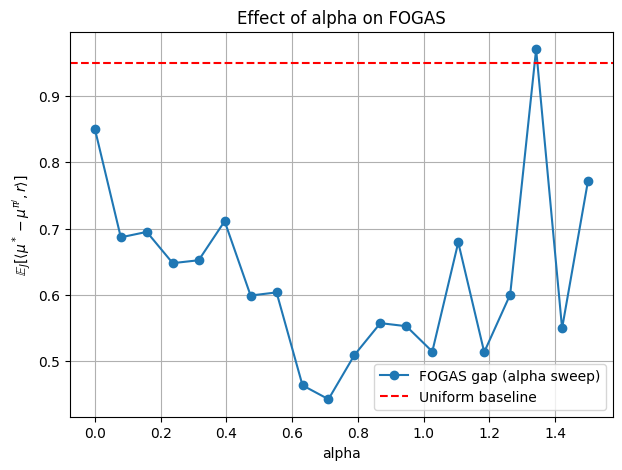

In [131]:
alpha_best_2donehot = fogas2d_onehot.sweep_parameter_and_plot("alpha", np.linspace(fogas2d_onehot.alpha, 1.5, 20), print_each=False)


=== Running FOGAS with eta = 7.07231264844686e-08
   Expected gap = 0.6078594826518147

=== Running FOGAS with eta = 3.728969900638982e-05
   Expected gap = 0.5465570396564521

=== Running FOGAS with eta = 7.450867488629516e-05
   Expected gap = 0.5195567886111666

=== Running FOGAS with eta = 0.00011172765076620051
   Expected gap = 0.5348939789793719

=== Running FOGAS with eta = 0.00014894662664610586
   Expected gap = 0.5355998004381586

=== Running FOGAS with eta = 0.00018616560252601123
   Expected gap = 0.3511893272571156

=== Running FOGAS with eta = 0.00022338457840591656
   Expected gap = 0.5048069651040205

=== Running FOGAS with eta = 0.0002606035542858219
   Expected gap = 0.496373277149852

=== Running FOGAS with eta = 0.0002978225301657273
   Expected gap = 0.4978924795674091

=== Running FOGAS with eta = 0.00033504150604563265
   Expected gap = 0.6365446927999228

=== Running FOGAS with eta = 0.000372260481925538
   Expected gap = 0.5321434587629874

=== Running FOGAS 

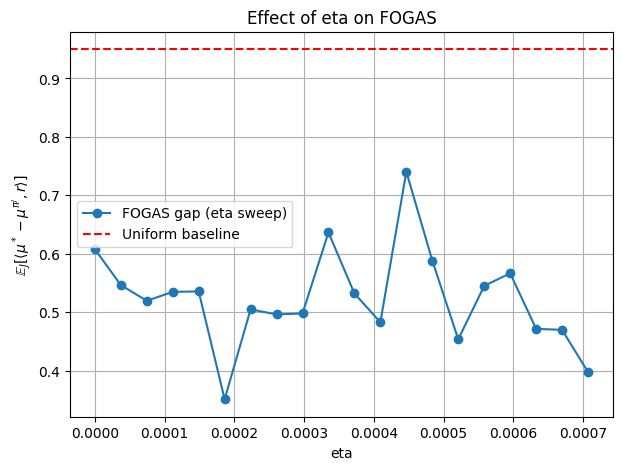


Best eta = 0.00018616560252601123
Best gap = 0.3511893272571156


In [133]:
fogas2d_onehot = FOGASSolver(mdp=mdp2D_onehot, alpha = alpha_best_2donehot, csv_path="datasets/dumb_problem.csv", print_params=False)
eta_best_2donehot = fogas2d_onehot.sweep_parameter_and_plot("eta", np.linspace(fogas2d_onehot.eta * 0.01, fogas2d_onehot.eta * 100, 20), print_each=True)


                FOGAS PARAMETER SUMMARY
Dataset size n:           100
Feature norm bound R:     10.0000
Num states N:             2
Num actions A:            2
Feature dim d:            4
Discount γ:               0.9

--- Theoretical Quantities ---
T_min (theoretical):      4627.5643
T (iterations):           4628
β (ridge param):          0.005402

--- FOGAS Hyperparameters ---
D_theta:                  6.324555
alpha:                    0.710572
rho:                      224.277488
eta:                      0.000186
D_pi:                     20798.468246

Phi shape: (100, 4)
Empirical Feature Covariance Matrix shape: (4, 4)
Inverse of Empirical Feature Covariance Matrix shape: (4, 4)

=== Running FOGAS with rho = 2.2427748789023694
   Expected gap = 0.298552071587006

=== Running FOGAS with rho = 2.1345322854088766
   Expected gap = 0.23834673344458937

=== Running FOGAS with rho = 2.0262896919153843
   Expected gap = 0.2133080253734796

=== Running FOGAS with rho = 1.9180470984218

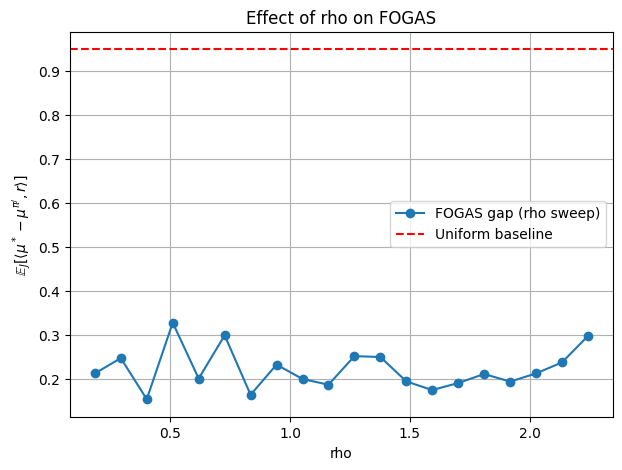


Best rho = 0.40265078951299627
Best gap = 0.15457823989301767


In [136]:
fogas2d_onehot = FOGASSolver(mdp=mdp2D_onehot, alpha = alpha_best_2donehot, eta=eta_best_2donehot, csv_path="datasets/dumb_problem.csv", print_params=True)
rho_best_2donehot = fogas2d_onehot.sweep_parameter_and_plot("rho", np.linspace(fogas2d_onehot.rho * 0.01, fogas2d_onehot.eta * 1000, 20), print_each=True)

#### 3d - features

In [9]:
fogas2d = FOGASSolver(mdp=mdp2D, csv_path="datasets/dumb_problem.csv", print_params=True)


                FOGAS PARAMETER SUMMARY
Dataset size n:           100
Feature norm bound R:     3.4641
Num states N:             2
Num actions A:            2
Feature dim d:            3
Discount γ:               0.9

--- Theoretical Quantities ---
T_min (theoretical):      555.3077
T (iterations):           556
β (ridge param):          0.007194

--- FOGAS Hyperparameters ---
D_theta:                  5.477226
alpha:                    0.000832
rho:                      152.808724
eta:                      0.000079
D_pi:                     2.534396

Phi shape: (100, 3)
Empirical Feature Covariance Matrix shape: (3, 3)
Inverse of Empirical Feature Covariance Matrix shape: (3, 3)


In [17]:
fogas2d.run(alpha = 0.1, print_policies=True, verbose=True)


Iteration 1
  State 0: π(a=0|s=0) = 0.62  π(a=1|s=0) = 0.38  --> best action: 0
  State 1: π(a=0|s=1) = 0.62  π(a=1|s=1) = 0.38  --> best action: 0

[FOGAS] Iter 1/556   ||θ̄_t|| = 5.4772

Iteration 56
  State 0: π(a=0|s=0) = 0.96  π(a=1|s=0) = 0.04  --> best action: 0
  State 1: π(a=0|s=1) = 0.96  π(a=1|s=1) = 0.04  --> best action: 0

[FOGAS] Iter 56/556   ||θ̄_t|| = 305.4527

Iteration 111
  State 0: π(a=0|s=0) = 0.94  π(a=1|s=0) = 0.06  --> best action: 0
  State 1: π(a=0|s=1) = 0.94  π(a=1|s=1) = 0.06  --> best action: 0

[FOGAS] Iter 111/556   ||θ̄_t|| = 606.4505

Iteration 166
  State 0: π(a=0|s=0) = 0.93  π(a=1|s=0) = 0.07  --> best action: 0
  State 1: π(a=0|s=1) = 0.93  π(a=1|s=1) = 0.07  --> best action: 0

[FOGAS] Iter 166/556   ||θ̄_t|| = 907.6257

Iteration 221
  State 0: π(a=0|s=0) = 0.93  π(a=1|s=0) = 0.07  --> best action: 0
  State 1: π(a=0|s=1) = 0.93  π(a=1|s=1) = 0.07  --> best action: 0

[FOGAS] Iter 221/556   ||θ̄_t|| = 1208.8424

Iteration 276
  State 0: π(a=0|

array([[0.94867887, 0.05132113],
       [0.94867887, 0.05132113]])

Why doesn't work: the four vectors are in the affine plane of 2 dimensions: (2, 0, 0) + span{(0, 2, 0), (0, 0, 2)} so them are dependent in this plane and the algorithm cannot work without the independence.

In [162]:
def phi3_2d(state, action):
    if state == 0 and action == 0:
        return np.array([1.0, 0.0, 0.0])
    if state == 0 and action == 1:
        return np.array([0.0, 1.0, 1.0])
    if state == 1 and action == 0:
        return np.array([1.0, 0.0, 1.0])
    if state == 1 and action == 1:
        return np.array([0.0, 1.0, 2.0])

omega3_2d = np.array([0.0, 0.0, 1.0])

psi3_2d = {
    0: np.array([1.0, 0.0, 0.0]),
    1: np.array([0.0, 1.0, 0.0]),
}

mdp3_2d = PolicySolver(states=states_2d,
                     actions=actions_2d,
                     phi=phi3_2d,
                     omega=omega3_2d,
                     gamma=gamma_2d,
                     x0=x_0,
                     psi=psi3_2d)

In [163]:
fogas2d_3 = FOGASSolver(mdp=mdp3_2d, csv_path="datasets/dumb_problem.csv", print_params=True)


                FOGAS PARAMETER SUMMARY
Dataset size n:           100
Feature norm bound R:     2.2361
Num states N:             2
Num actions A:            2
Feature dim d:            3
Discount γ:               0.9

--- Theoretical Quantities ---
T_min (theoretical):      231.3782
T (iterations):           232
β (ridge param):          0.007184

--- FOGAS Hyperparameters ---
D_theta:                  5.477226
alpha:                    0.001996
rho:                      145.984817
eta:                      0.000188
D_pi:                     2.536219

Phi shape: (100, 3)
Empirical Feature Covariance Matrix shape: (3, 3)
Inverse of Empirical Feature Covariance Matrix shape: (3, 3)


In [164]:
fogas2d_3.run(print_policies=True)


Iteration 1
  State 0: π(a=0|s=0) = 0.50  π(a=1|s=0) = 0.50  --> best action: 0
  State 1: π(a=0|s=1) = 0.50  π(a=1|s=1) = 0.50  --> best action: 0


Iteration 24
  State 0: π(a=0|s=0) = 0.53  π(a=1|s=0) = 0.47  --> best action: 0
  State 1: π(a=0|s=1) = 0.53  π(a=1|s=1) = 0.47  --> best action: 0


Iteration 47
  State 0: π(a=0|s=0) = 0.55  π(a=1|s=0) = 0.45  --> best action: 0
  State 1: π(a=0|s=1) = 0.55  π(a=1|s=1) = 0.45  --> best action: 0


Iteration 70
  State 0: π(a=0|s=0) = 0.57  π(a=1|s=0) = 0.43  --> best action: 0
  State 1: π(a=0|s=1) = 0.57  π(a=1|s=1) = 0.43  --> best action: 0


Iteration 93
  State 0: π(a=0|s=0) = 0.58  π(a=1|s=0) = 0.42  --> best action: 0
  State 1: π(a=0|s=1) = 0.58  π(a=1|s=1) = 0.42  --> best action: 0


Iteration 116
  State 0: π(a=0|s=0) = 0.59  π(a=1|s=0) = 0.41  --> best action: 0
  State 1: π(a=0|s=1) = 0.59  π(a=1|s=1) = 0.41  --> best action: 0


Iteration 139
  State 0: π(a=0|s=0) = 0.60  π(a=1|s=0) = 0.40  --> best action: 0
  State 1: 

array([[0.61953599, 0.38046401],
       [0.61953599, 0.38046401]])

## 3x3 Grid

### Description

**State space.**
The states are encoded as integers
$\mathcal{X} = {0,1,\dots,8}$,
corresponding to the grid in row-major order. State $8$ is the terminal goal state and is absorbing.

**Action space.**
Actions are represented as integers

$ \mathcal{A} = {0,1,2,3} $,

where $0 =$ Up, $1 =$ Down, $2 =$ Left, $3 =$ Right.

**Transition dynamics.**
Transitions are deterministic. For any state $x$ and action $a$, the state index is first mapped to its grid coordinates $(r,c)$, the action moves the agent one step (unless this would leave the grid), and the result is mapped back to a state index. The goal state $8$ always transitions to itself.
The transition matrix $P$ has shape $(|\mathcal{X}||\mathcal{A}|) \times |\mathcal{X}| = 36 \times 9$, where each row corresponds to a pair $(x,a)$ and contains a one-hot vector indicating the unique next state:

$P[(x,a),x'] = 1 \quad \text{iff } x' = \text{next\_state}(x,a),$

and $0$ otherwise.

**Feature map.**
We use $d = 5$ features. The feature vector for $(x,a)$ is

$ \phi(x,a) = [1, \text{row}(x), \text{col}(x), a, \mathbf{1}_{x = 8}], $

where $\text{row}(x) = x // 3$ and $\text{col}(x) = x % 3$. The last component is a goal indicator.

**Reward model.**
Rewards are linear in $\phi(x,a)$:
$ r(x,a) = \phi(x,a)^\top \omega, $
with

$ \omega = [0, 0, 0, 0, 1]. $

Thus $r(x,a) = 1$ only when $x$ is the goal state, and $0$ otherwise.

**Discount factor.**
We set $\gamma = 0.9$.

**Initial state.**
The initial state is fixed as $x_0 = 0$.

### Creation of the environment

Creation of 2 different type of features.

In [14]:
states_grid = np.arange(9)
actions_grid = np.arange(4)
N = len(states_grid) # number of states
A = len(actions_grid) # number of actions
gamma_grid = 0.9

x_0_grid = 0 # fixed initial state
dataset_path_grid = "datasets/grid3_problem.csv" # path where to download the dataset

goal_grid = 8   # absorbing terminal state

def phi_grid_5(state, action):
    is_goal = float(state == goal_grid)
    return np.array([1.0, float(state // 3), float(state % 3), float(action), is_goal])

def phi_grid_onehot(x, a):
    vec = np.zeros(N * A)
    vec[x * A + a] = 1.0
    return vec

omega_grid5= np.array([0, 0, 0, 0, 1.0]) 

omega_grid_onehot = np.zeros(N*A)
omega_grid_onehot[8 * A : 8* A + 3] = 1

Prob matrix

In [15]:
# Helper to convert index <-> (row, col)
def to_rc(s):  return divmod(s, 3)
def to_s(r,c): return r*3 + c

def next_state(s, a):
    if s == goal_grid:
        return goal_grid  # absorbing: if we reach that state we stay in that state

    r, c = to_rc(s)

    if a == 0:  # Up
        r = max(0, r-1)
    elif a == 1:  # Down
        r = min(2, r+1)
    elif a == 2:  # Left
        c = max(0, c-1)
    elif a == 3:  # Right
        c = min(2, c+1)

    return to_s(r, c)

P_grid = np.zeros((N * A, N))
count = 0
for x in range(N):
    for a in range(A):
        xp = next_state(x, a)     # deterministic next state
        for xp_ in range(N):
            if xp_ == xp:
                P_grid[count, xp_] = 1.0
            else:
                P_grid[count, xp_] = 0.0
        count += 1

In [16]:
mdpGrid_5d = PolicySolver(states=states_grid, actions=actions_grid, phi=phi_grid_5, omega=omega_grid5, gamma=gamma_grid, x0=x_0_grid, P=P_grid)
mdpGrid_onehot = PolicySolver(states=states_grid, actions=actions_grid, phi=phi_grid_onehot, omega=omega_grid_onehot, gamma=gamma_grid, x0=x_0_grid, P=P_grid)

### Testing 

#### One-hot features

In [145]:
fogas_grid_oh = FOGASSolver(mdp=mdpGrid_onehot, csv_path=dataset_path_grid, print_params=True)


                FOGAS PARAMETER SUMMARY
Dataset size n:           150
Feature norm bound R:     1.0000
Num states N:             9
Num actions A:            4
Feature dim d:            36
Discount γ:               0.9

--- Theoretical Quantities ---
T_min (theoretical):      138.8269
T (iterations):           139
β (ridge param):          0.000200

--- FOGAS Hyperparameters ---
D_theta:                  18.973666
alpha:                    0.002354
rho:                      1389.672495
eta:                      0.000045
D_pi:                     6.207977

Phi shape: (150, 36)
Empirical Feature Covariance Matrix shape: (36, 36)
Inverse of Empirical Feature Covariance Matrix shape: (36, 36)


In [146]:
fogas_grid_oh.run(print_policies=True, verbose=True)


Iteration 1
  State 0: π(a=0|s=0) = 0.25  π(a=1|s=0) = 0.25  π(a=2|s=0) = 0.25  π(a=3|s=0) = 0.25  --> best action: 0
  State 1: π(a=0|s=1) = 0.25  π(a=1|s=1) = 0.25  π(a=2|s=1) = 0.25  π(a=3|s=1) = 0.25  --> best action: 0
  State 2: π(a=0|s=2) = 0.25  π(a=1|s=2) = 0.25  π(a=2|s=2) = 0.25  π(a=3|s=2) = 0.25  --> best action: 0
  State 3: π(a=0|s=3) = 0.25  π(a=1|s=3) = 0.25  π(a=2|s=3) = 0.25  π(a=3|s=3) = 0.25  --> best action: 0
  State 4: π(a=0|s=4) = 0.25  π(a=1|s=4) = 0.25  π(a=2|s=4) = 0.25  π(a=3|s=4) = 0.25  --> best action: 0
  State 5: π(a=0|s=5) = 0.25  π(a=1|s=5) = 0.25  π(a=2|s=5) = 0.25  π(a=3|s=5) = 0.25  --> best action: 0
  State 6: π(a=0|s=6) = 0.25  π(a=1|s=6) = 0.25  π(a=2|s=6) = 0.25  π(a=3|s=6) = 0.25  --> best action: 0
  State 7: π(a=0|s=7) = 0.25  π(a=1|s=7) = 0.25  π(a=2|s=7) = 0.25  π(a=3|s=7) = 0.25  --> best action: 0
  State 8: π(a=0|s=8) = 0.25  π(a=1|s=8) = 0.25  π(a=2|s=8) = 0.25  π(a=3|s=8) = 0.25  --> best action: 0

[FOGAS] Iter 1/139   ||θ̄_t|| = 

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])


=== Running FOGAS with alpha = 2.3538786817932397e-06
   Expected gap = 0.5184835884844163

=== Running FOGAS with alpha = 0.024140203744934145
   Expected gap = 0.516509374008258

=== Running FOGAS with alpha = 0.04827805361118649
   Expected gap = 0.5130531714801421

=== Running FOGAS with alpha = 0.07241590347743884
   Expected gap = 0.5128437050033546

=== Running FOGAS with alpha = 0.09655375334369119
   Expected gap = 0.5094766160873957

=== Running FOGAS with alpha = 0.12069160320994354
   Expected gap = 0.5114418848227785

=== Running FOGAS with alpha = 0.1448294530761959
   Expected gap = 0.5077737711083831

=== Running FOGAS with alpha = 0.16896730294244827
   Expected gap = 0.5088021549141865

=== Running FOGAS with alpha = 0.1931051528087006
   Expected gap = 0.5022534757443122

=== Running FOGAS with alpha = 0.21724300267495295
   Expected gap = 0.5073267505192602

=== Running FOGAS with alpha = 0.2413808525412053
   Expected gap = 0.5064797062244132

=== Running FOGAS wi

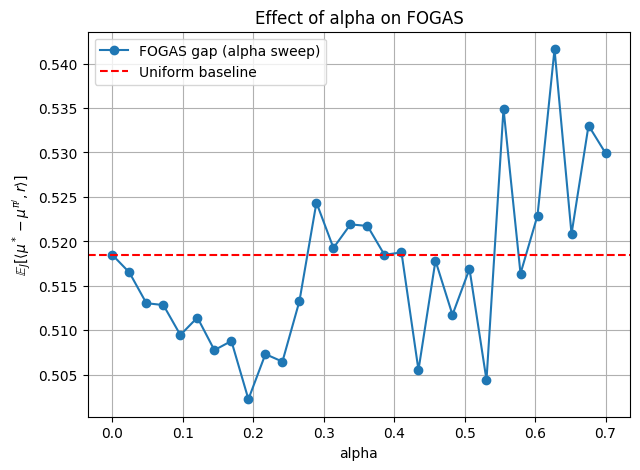


Best alpha = 0.1931051528087006
Best gap = 0.5022534757443122


In [149]:
alpha_best_gridonehot = fogas_grid_oh.sweep_parameter_and_plot("alpha", np.linspace(fogas_grid_oh.alpha * 0.001, 0.7, 30), print_each=True)


=== Running FOGAS with eta = 4.534278767355478e-08
   Expected gap = 0.5184002037982122

=== Running FOGAS with eta = 0.0002386892072386106
   Expected gap = 0.5063750514405303

=== Running FOGAS with eta = 0.00047733307168954767
   Expected gap = 0.506011394861414

=== Running FOGAS with eta = 0.0007159769361404847
   Expected gap = 0.5022781384338155

=== Running FOGAS with eta = 0.0009546208005914217
   Expected gap = 0.5036303027208178

=== Running FOGAS with eta = 0.001193264665042359
   Expected gap = 0.5027097929930653

=== Running FOGAS with eta = 0.001431908529493296
   Expected gap = 0.5051114414190194

=== Running FOGAS with eta = 0.001670552393944233
   Expected gap = 0.503894152014223

=== Running FOGAS with eta = 0.00190919625839517
   Expected gap = 0.5033334436108683

=== Running FOGAS with eta = 0.002147840122846107
   Expected gap = 0.5038057348031785

=== Running FOGAS with eta = 0.002386483987297044
   Expected gap = 0.5019954187252411

=== Running FOGAS with eta =

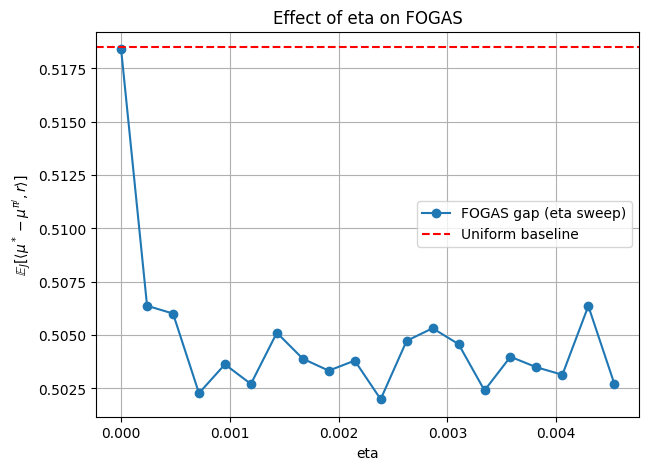


Best eta = 0.002386483987297044
Best gap = 0.5019954187252411


In [151]:
fogas_grid_oh = FOGASSolver(mdp=mdpGrid_onehot, csv_path=dataset_path_grid, alpha=alpha_best_gridonehot)
eta_best_gridonehot = fogas_grid_oh.sweep_parameter_and_plot("eta", np.linspace(fogas_grid_oh.eta * 0.001, fogas_grid_oh.eta * 100, 20), print_each=True)


=== Running FOGAS with rho = 0.13896724948884073
   Expected gap = 0.2761472257153188

=== Running FOGAS with rho = 0.2047938413519758
   Expected gap = 0.27643480699149203

=== Running FOGAS with rho = 0.27062043321511087
   Expected gap = 0.243349440838018

=== Running FOGAS with rho = 0.336447025078246
   Expected gap = 0.24975896414441015

=== Running FOGAS with rho = 0.4022736169413811
   Expected gap = 0.2839625838418173

=== Running FOGAS with rho = 0.4681002088045162
   Expected gap = 0.29212586273430163

=== Running FOGAS with rho = 0.5339268006676512
   Expected gap = 0.32033284618860786

=== Running FOGAS with rho = 0.5997533925307863
   Expected gap = 0.2575346084832345

=== Running FOGAS with rho = 0.6655799843939214
   Expected gap = 0.2613064836489351

=== Running FOGAS with rho = 0.7314065762570565
   Expected gap = 0.28461018675356314

=== Running FOGAS with rho = 0.7972331681201916
   Expected gap = 0.25233619434006277

=== Running FOGAS with rho = 0.8630597599833266

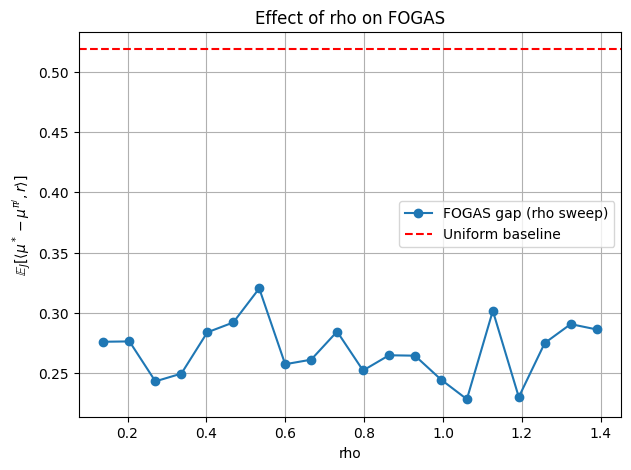


Best rho = 1.0605395355727318
Best gap = 0.22854187999981024


In [154]:
fogas_grid_oh = FOGASSolver(mdp=mdpGrid_onehot, csv_path=dataset_path_grid, alpha=alpha_best_gridonehot, eta = eta_best_gridonehot)
rho_best_gridonehot = fogas_grid_oh.sweep_parameter_and_plot("rho", np.linspace(fogas_grid_oh.rho * 0.0001, fogas_grid_oh.rho* 0.001, 20), print_each=True)

In [157]:
final_grid_onehot = FOGASSolver(mdp=mdpGrid_onehot, csv_path=dataset_path_grid, alpha=alpha_best_gridonehot, eta = eta_best_gridonehot, rho = rho_best_gridonehot, T=400)
final_pi_grid_oh = final_grid_onehot.run()

In [158]:
mdpGrid_onehot.print_policy(final_pi_grid_oh)

  State 0: π(a=0|s=0) = 0.00  π(a=1|s=0) = 0.86  π(a=2|s=0) = 0.00  π(a=3|s=0) = 0.14  --> best action: 1
  State 1: π(a=0|s=1) = 0.17  π(a=1|s=1) = 0.41  π(a=2|s=1) = 0.00  π(a=3|s=1) = 0.42  --> best action: 3
  State 2: π(a=0|s=2) = 0.27  π(a=1|s=2) = 0.43  π(a=2|s=2) = 0.00  π(a=3|s=2) = 0.30  --> best action: 1
  State 3: π(a=0|s=3) = 0.00  π(a=1|s=3) = 0.47  π(a=2|s=3) = 0.19  π(a=3|s=3) = 0.34  --> best action: 1
  State 4: π(a=0|s=4) = 0.00  π(a=1|s=4) = 0.48  π(a=2|s=4) = 0.00  π(a=3|s=4) = 0.52  --> best action: 3
  State 5: π(a=0|s=5) = 0.03  π(a=1|s=5) = 0.66  π(a=2|s=5) = 0.06  π(a=3|s=5) = 0.24  --> best action: 1
  State 6: π(a=0|s=6) = 0.00  π(a=1|s=6) = 0.26  π(a=2|s=6) = 0.23  π(a=3|s=6) = 0.51  --> best action: 3
  State 7: π(a=0|s=7) = 0.08  π(a=1|s=7) = 0.30  π(a=2|s=7) = 0.15  π(a=3|s=7) = 0.47  --> best action: 3
  State 8: π(a=0|s=8) = 0.42  π(a=1|s=8) = 0.42  π(a=2|s=8) = 0.08  π(a=3|s=8) = 0.07  --> best action: 0



#### 5d features

In [159]:
fogas_grid_5d = FOGASSolver(mdp=mdpGrid_5d, csv_path=dataset_path_grid, print_params=True)


                FOGAS PARAMETER SUMMARY
Dataset size n:           150
Feature norm bound R:     4.3589
Num states N:             9
Num actions A:            4
Feature dim d:            5
Discount γ:               0.9

--- Theoretical Quantities ---
T_min (theoretical):      2637.7116
T (iterations):           2638
β (ridge param):          0.001440

--- FOGAS Hyperparameters ---
D_theta:                  7.071068
alpha:                    0.000333
rho:                      223.535127
eta:                      0.000017
D_pi:                     6.204450

Phi shape: (150, 5)
Empirical Feature Covariance Matrix shape: (5, 5)
Inverse of Empirical Feature Covariance Matrix shape: (5, 5)


In [161]:
mdpGrid_5d.print_policy(fogas_grid_5d.run(print_policies=True, verbose=True))


Iteration 1
  State 0: π(a=0|s=0) = 0.25  π(a=1|s=0) = 0.25  π(a=2|s=0) = 0.25  π(a=3|s=0) = 0.25  --> best action: 0
  State 1: π(a=0|s=1) = 0.25  π(a=1|s=1) = 0.25  π(a=2|s=1) = 0.25  π(a=3|s=1) = 0.25  --> best action: 0
  State 2: π(a=0|s=2) = 0.25  π(a=1|s=2) = 0.25  π(a=2|s=2) = 0.25  π(a=3|s=2) = 0.25  --> best action: 0
  State 3: π(a=0|s=3) = 0.25  π(a=1|s=3) = 0.25  π(a=2|s=3) = 0.25  π(a=3|s=3) = 0.25  --> best action: 0
  State 4: π(a=0|s=4) = 0.25  π(a=1|s=4) = 0.25  π(a=2|s=4) = 0.25  π(a=3|s=4) = 0.25  --> best action: 0
  State 5: π(a=0|s=5) = 0.25  π(a=1|s=5) = 0.25  π(a=2|s=5) = 0.25  π(a=3|s=5) = 0.25  --> best action: 0
  State 6: π(a=0|s=6) = 0.25  π(a=1|s=6) = 0.25  π(a=2|s=6) = 0.25  π(a=3|s=6) = 0.25  --> best action: 0
  State 7: π(a=0|s=7) = 0.25  π(a=1|s=7) = 0.25  π(a=2|s=7) = 0.25  π(a=3|s=7) = 0.25  --> best action: 0
  State 8: π(a=0|s=8) = 0.25  π(a=1|s=8) = 0.25  π(a=2|s=8) = 0.25  π(a=3|s=8) = 0.25  --> best action: 0

[FOGAS] Iter 1/2638   ||θ̄_t|| =

KeyboardInterrupt: 

#### Queueing system

In [ ]:
states_queue = np.arange(9)
actions_queue = np.arange(4)
N = len(states_grid) # number of states
A = len(actions_grid) # number of actions
gamma_queue = 0.9

x_0_queue = 0 # fixed initial state
dataset_path_grid = "datasets/grid3_problem.csv" # path where to download the dataset

goal_grid = 8   # absorbing terminal state

def phi_grid_5(state, action):
    is_goal = float(state == goal_grid)
    return np.array([1.0, float(state // 3), float(state % 3), float(action), is_goal])

def phi_grid_onehot(x, a):
    vec = np.zeros(N * A)
    vec[x * A + a] = 1.0
    return vec

omega_grid5= np.array([0, 0, 0, 0, 1.0]) 

omega_grid_onehot = np.zeros(N*A)
omega_grid_onehot[8 * A : 8* A + 3] = 1